## 导入必要的安装包

In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import os 
from tqdm import tqdm
import glob
ts.set_token('ce1d8f98f48f0c92fa70a66528612510f350b82ea565bc1abd45b5ac')
debug = False
from datetime import datetime 
pro = ts.pro_api()

## 生成Alpha因子的基础函数

In [2]:
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_median(df, window=10):
    return df.rolling(window).median()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1 


## 一系列Alpha因子

In [4]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap'] 
        self.volume = daily_info['volume'] 
        self.amount = daily_info['amount']

    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
        alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
        alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
        alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
        alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
        alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
        alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
        alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
        alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
        alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
        alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
        alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close
      
        tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
        alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
        alpha_dict['alpha30']=tmp2/delay(tmp2,4)

        tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

        tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)
        
        alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
        alpha_dict['alpha_pe']= -1*daily_info['pe_ttm']
        alpha_dict['alpha_total_mv']= daily_info['total_mv']
        alpha_dict['alpha_pb']= -1*daily_info['pb']
        alpha_dict['alpha_turnover_rate']= daily_info['turnover_rate']
        alpha_dict['alpha_volume_ratio']= daily_info['volume_ratio']
        alpha_dict['alpha_vwap']= daily_info['vwap']
        alpha_dict['alpha_dv_ttm']= -1*daily_info['dv_ttm']
        return alpha_dict
        

## 生成训练集

In [5]:
pro = ts.pro_api()
all_stock = pro.stock_basic()
price_PD_total = pd.read_csv('data/price_PD.csv', dtype = {'trade_date': 'str'})
price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
all_stock = all_stock[['ts_code','name','market','industry']]
price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
price_PD_total = price_PD_total[['ts_code', 'name','market','industry', 'trade_date', 'open', 'high', 'low',
       'close', 'pre_close','change', 'pct_chg', 'vol', 'amount']]
price_PD_total = price_PD_total[price_PD_total.market.isin(['主板','中小板','创业板'])]
price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)

In [6]:

daily_basic = pd.read_csv('data/daily_basic.csv', dtype = {'trade_date': 'str'})
daily_basic

,ts_code,trade_date,turnover_rate,turnover_rate_f,volume_ratio,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv
0,000001.SZ,20190102,0.3141,0.7088,0.99,6.8048,6.4428,0.7330,1.4917,1.4012,1.4799,1.4799,1.717041e+06,1.717025e+06,761029.0923,1.577961e+07,1.577946e+07
1,000001.SZ,20190103,0.2420,0.5460,0.76,6.8714,6.5059,0.7402,1.5063,1.4149,1.4655,1.4655,1.717041e+06,1.717025e+06,761029.0923,1.593414e+07,1.593399e+07
2,000001.SZ,20190104,0.8626,1.9463,2.87,7.2194,6.7456,0.7607,1.5825,1.4343,1.3949,1.3949,1.717041e+06,1.717025e+06,761029.0923,1.674115e+07,1.674099e+07
3,000001.SZ,20190107,0.5042,1.1375,1.19,7.2120,6.7386,0.7599,1.5809,1.4329,1.3963,1.3963,1.717041e+06,1.717025e+06,761029.0923,1.672398e+07,1.672382e+07
4,000001.SZ,20190108,0.2344,0.5287,0.52,7.1528,6.6833,0.7536,1.5679,1.4211,1.4079,1.4079,1.717041e+06,1.717025e+06,761029.0923,1.658662e+07,1.658646e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6718158,920128.BJ,20250122,5.5613,5.5613,0.87,50.1866,48.6791,4.2442,3.9764,3.7950,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.277380e+05,4.796550e+04
6718159,920128.BJ,20250123,5.8266,5.8266,1.02,49.9898,48.4882,4.2276,3.9608,3.7802,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.268449e+05,4.777740e+04
6718160,920128.BJ,20250124,3.9659,3.9659,0.74,49.7393,48.2453,4.2064,3.9409,3.7612,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.257082e+05,4.753800e+04
6718161,920128.BJ,20250127,3.0706,3.0706,0.61,49.6856,48.1932,4.2018,3.9367,3.7572,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.254646e+05,4.748670e+04


In [7]:
price_PD_total = pd.merge(price_PD_total,daily_basic,how='left',on=['ts_code','trade_date'])


In [8]:
##计算开盘涨幅
price_PD_total['open_up'] = price_PD_total.groupby('ts_code').open.shift(1)/price_PD_total.groupby('ts_code').close.shift(0)

In [9]:
#t收盘买 t+1收盘卖
price_PD_total['ret1'] = price_PD_total.groupby('ts_code').close.shift(-1)/price_PD_total.groupby('ts_code').close.shift(0) 
#t+1开盘买 t+2收盘卖
price_PD_total['ret2'] = price_PD_total.groupby('ts_code').close.shift(-2)/price_PD_total.groupby('ts_code').open.shift(-1) 
#t+1开盘买 t+2开盘卖
# price_PD_total['ret3'] = price_PD_total.groupby('ts_code').open.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1) 
# #t+1开盘买 t+3收盘卖
# price_PD_total['ret4'] = price_PD_total.groupby('ts_code').close.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1)
# #t+1开盘买 t+4收盘卖
# price_PD_total['ret5'] = price_PD_total.groupby('ts_code').close.shift(-4)/price_PD_total.groupby('ts_code').open.shift(-1)

price_PD_total['ret'] = price_PD_total['ret2'].copy()



In [10]:

daily_info = {}
daily_info['open'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='open')
daily_info['close'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='close')
daily_info['high']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='high')
daily_info['low']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='low')
daily_info['volume']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='vol')
daily_info['amount']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='amount')
daily_info['vwap']  = (daily_info['amount']*1000)/(daily_info['volume']*100+1) 
daily_info['pe_ttm']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='pe_ttm')
daily_info['total_mv']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='total_mv')
daily_info['pb']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='pb')
daily_info['turnover_rate']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='turnover_rate')
daily_info['volume_ratio']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='volume_ratio')
daily_info['dv_ttm']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='dv_ttm')


In [11]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [12]:
data = pd.DataFrame()
for k, v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['ts_code', 'trade_date'])

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:48<00:00,  3.39s/it]


In [13]:
data = pd.merge(data, price_PD_total[['trade_date', 'ts_code','name', 'ret1', 'ret2', \
                                    'ret','open_up']], how='left', on=['trade_date', 'ts_code'])

In [14]:
data

,ts_code,trade_date,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha_pb,alpha_turnover_rate,alpha_volume_ratio,alpha_vwap,alpha_dv_ttm,name,ret1,ret2,ret,open_up
0,000001.SZ,20190102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.7330,0.3141,0.99,9.245602,-1.4799,平安银行,1.009793,1.062092,1.062092,NaN
1,000001.SZ,20190103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.7402,0.2420,0.76,9.252048,-1.4655,平安银行,1.050647,1.054113,1.054113,1.011853
2,000001.SZ,20190104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.7607,0.8626,2.87,9.601601,-1.3949,平安银行,0.998974,0.981707,0.981707,0.941538
3,000001.SZ,20190107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.7599,0.5042,1.19,9.716743,-1.3963,平安银行,0.991786,1.021583,1.021583,0.948665
4,000001.SZ,20190108,NaN,0.002608,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.7536,0.2344,0.52,9.673442,-1.4079,平安银行,1.028986,1.036961,1.036961,1.018634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6513595,605599.SH,20250122,5.334277e-07,0.000029,4.240551e-07,2.418639e-06,-0.000006,0.000031,0.000010,0.000022,...,-2.2152,0.2994,0.72,10.808407,-6.4220,菜百股份,1.001835,1.010969,1.010969,0.998165
6513596,605599.SH,20250123,3.943528e-07,0.000021,1.997261e-07,2.006077e-07,-0.000005,0.000026,0.000002,0.000018,...,-2.2193,0.2699,0.75,10.958126,-6.4103,菜百股份,1.012821,1.031193,1.031193,0.990842
6513597,605599.SH,20250124,6.292180e-07,0.000022,1.743784e-07,5.847378e-07,-0.000005,0.000029,0.000002,0.000020,...,-2.2477,0.3048,0.96,10.983204,-6.3291,菜百股份,1.016275,0.974706,0.974706,0.989150
6513598,605599.SH,20250127,1.267579e-06,0.000026,3.013898e-07,1.502688e-06,-0.000005,0.000031,0.000003,0.000022,...,-2.2843,0.4231,1.49,11.249939,-6.2278,菜百股份,0.959964,NaN,NaN,0.969751


In [15]:
price_PD_total.columns

Index(['ts_code', 'name', 'market', 'industry', 'trade_date', 'open', 'high',
       'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount',
       'turnover_rate', 'turnover_rate_f', 'volume_ratio', 'pe', 'pe_ttm',
       'pb', 'ps', 'ps_ttm', 'dv_ratio', 'dv_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'open_up', 'ret1',
       'ret2', 'ret'],
      dtype='object')

In [19]:
train = data.copy()
train = train[train.trade_date < '20240101']#.dropna()

train['ret_rank'] = train.groupby('trade_date').ret.rank(pct=True)
train = train[~train.ret_rank.isna()].reset_index(drop=True)

from sklearn.model_selection import KFold,GroupKFold,train_test_split

kfold = KFold(n_splits = 10, shuffle = True, random_state = 42)

enumsplit = []
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
    enumsplit.append([trn_ind, val_ind])  
enumsplit

[[array([      1,       2,       3, ..., 4587190, 4587191, 4587192]),
  array([      0,       8,      12, ..., 4587174, 4587175, 4587180])],
 [array([      0,       1,       3, ..., 4587190, 4587191, 4587192]),
  array([      2,      13,      26, ..., 4587163, 4587176, 4587177])],
 [array([      0,       1,       2, ..., 4587189, 4587190, 4587192]),
  array([      3,       9,      22, ..., 4587186, 4587187, 4587191])],
 [array([      0,       2,       3, ..., 4587190, 4587191, 4587192]),
  array([      1,       5,       7, ..., 4587166, 4587167, 4587183])],
 [array([      0,       1,       2, ..., 4587189, 4587190, 4587191]),
  array([     11,      33,      40, ..., 4587181, 4587184, 4587192])],
 [array([      0,       1,       2, ..., 4587190, 4587191, 4587192]),
  array([     20,      56,      59, ..., 4587182, 4587185, 4587188])],
 [array([      0,       1,       2, ..., 4587190, 4587191, 4587192]),
  array([     14,      18,      44, ..., 4587146, 4587152, 4587189])],
 [array([    

In [20]:
train.columns

Index(['ts_code', 'trade_date', 'alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'alpha_pe', 'alpha_total_mv',
       'alpha_pb', 'alpha_turnover_rate', 'alpha_volume_ratio', 'alpha_vwap',
       'alpha_dv_ttm', 'name', 'ret1', 'ret2', 'ret', 'open_up', 'ret_rank'],
      dtype='object')

In [21]:
features = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'alpha_pe', 'alpha_total_mv',
       'alpha_pb', 'alpha_turnover_rate', 'alpha_volume_ratio', 'alpha_vwap',
       'alpha_dv_ttm']


## 模型训练

In [22]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

modellist = []
y = train['ret_rank']
# y = train['ret']

oof_predictions = np.zeros(train.shape[0])

for fold, (trn_ind, val_ind) in enumerate(enumsplit):
    print(f'Training fold {fold + 1}')
    x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
    y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
    train_dataset = lgb.Dataset(x_train[features], y_train)
    val_dataset = lgb.Dataset(x_val[features], y_val)
    model = lgb.LGBMRegressor()
    model.fit(x_train[features],y_train)
    modellist.append(model)
    oof_predictions[val_ind] = model.predict(x_val[features])
    print(f'fold RMSPE is {mean_squared_error(y_val, oof_predictions[val_ind])**0.5}')
    corrr_score = np.corrcoef([y_val, oof_predictions[val_ind]])[0,1]
    print(f'fold CORR is {corrr_score}')

rmspe_score = mean_squared_error(y, oof_predictions)**0.5
print(f'Our out of folds RMSE is {rmspe_score}')
corrr_score = np.corrcoef([y, oof_predictions])[0,1]
print(f'Our out of folds CORR is {corrr_score}')

Training fold 1
fold RMSPE is 0.28783522348747304
fold CORR is 0.0878874834326005
Training fold 2
fold RMSPE is 0.28764702127484254
fold CORR is 0.08775046885207116
Training fold 3
fold RMSPE is 0.2874596957361424
fold CORR is 0.08681249666246614
Training fold 4
fold RMSPE is 0.2873658988547038
fold CORR is 0.08981586773550171
Training fold 5
fold RMSPE is 0.28749723079663525
fold CORR is 0.08934258346587802
Training fold 6
fold RMSPE is 0.28742120581342795
fold CORR is 0.09104979503392718
Training fold 7
fold RMSPE is 0.28770529133729844
fold CORR is 0.08878233581061093
Training fold 8
fold RMSPE is 0.28738203901398734
fold CORR is 0.09132704888140823
Training fold 9
fold RMSPE is 0.28742034898832447
fold CORR is 0.0921965032952745
Training fold 10
fold RMSPE is 0.2876201142016606
fold CORR is 0.0923553431024333
Our out of folds RMSPE is 0.28753544599420516
Our out of folds CORR is 0.08972567469250581


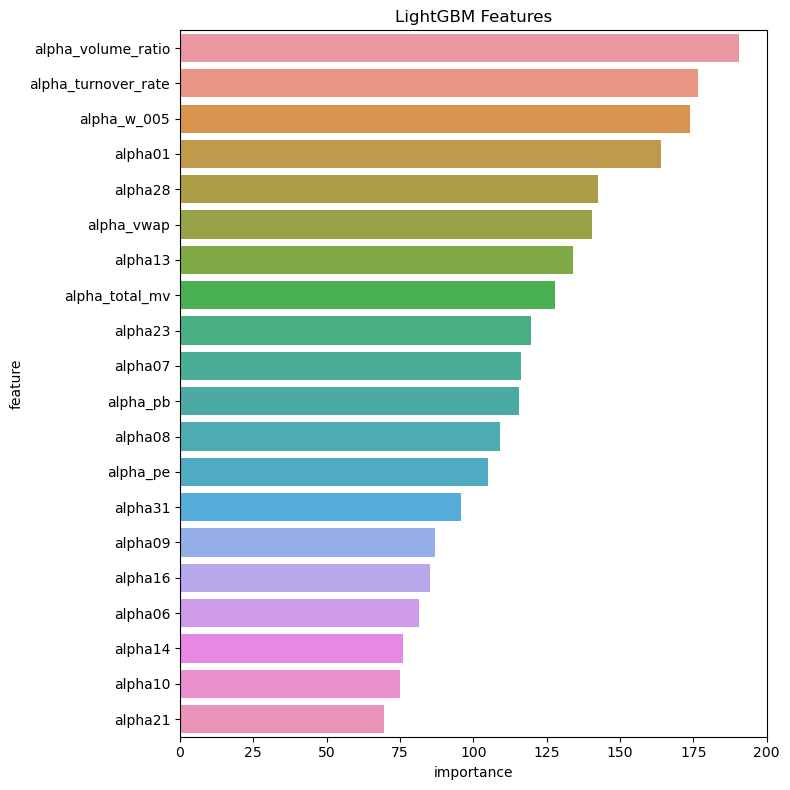

In [23]:
def print_gbm_model_feature_importance(model):
    feature_names = features
    try:
        importances = list(model.feature_importances_)
    except:
        importances = list(model.feature_importance())
    feature_importances = [(feature,round(importance)) for feature,importance in zip(feature_names,importances)]
    feature_importances = sorted(feature_importances,key=lambda x:x[1],reverse=True)
    #print(feature_importances)
    return feature_importances
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_df = []
for model in modellist:
    feature_importance_df_ = print_gbm_model_feature_importance(model)
    feature_importance_df_ = pd.DataFrame(feature_importance_df_)
    feature_importance_df_.columns = ["feature", "importance"]
    feature_importance_df.append(feature_importance_df_)
feature_importance_df = pd.concat(feature_importance_df)
feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean().reset_index()

sss = feature_importance_df.sort_values(by="importance", ascending=False).head(20)

plt.figure(figsize=(8,8))
sns.barplot(x="importance", y="feature", 
            data=sss)
plt.title('LightGBM Features')
plt.tight_layout()

## 分组法测有效性

In [24]:

test = data.copy()
test = test[test.trade_date > '20240101']
pred = np.zeros(test.shape[0])
for model in modellist:
    pred += model.predict(test[features])
test['pred'] = pred
date_calc = sorted(test.trade_date.unique())



In [25]:
test = pd.merge(test,all_stock[['ts_code','industry']],how='left',on='ts_code')

In [26]:

test['factor_rank'] = test.groupby(['trade_date','industry']).pred.rank(pct=True,method='dense')


In [27]:
def fun(x):
    if np.isnan(x):
        return np.nan
    else:
        return min(10,int(x*10)+1)
    
test['factor_rank_bin'] = test.factor_rank.apply(fun)

In [28]:
test.factor_rank_bin.value_counts()

10    135551
6     119095
3     117922
9     116397
7     115251
8     114457
2     112932
4     111786
5     111277
1      97908
Name: factor_rank_bin, dtype: int64

<AxesSubplot:xlabel='trade_date'>

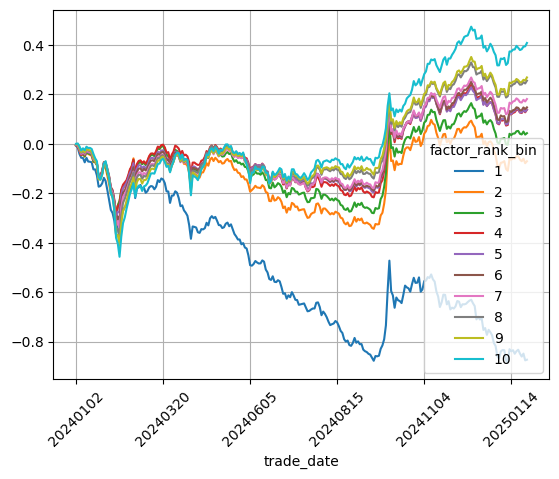

In [29]:
(test.groupby(['factor_rank_bin', \
        'trade_date']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45,grid=True)

<AxesSubplot:xlabel='trade_date'>

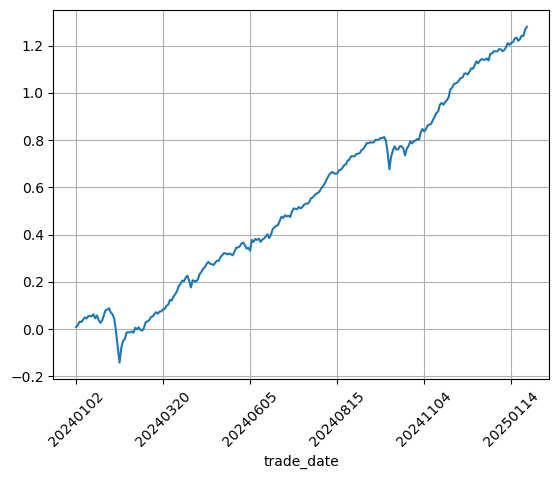

In [30]:
##计算做多做空收益
##做多factor最大的一组，做空factor最小的一组

long_ret = (test[(test.factor_rank_bin == 10)].groupby('trade_date').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 1)].groupby('trade_date').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

In [31]:
ret_PD = (test.groupby(['factor_rank_bin', 'trade_date']).ret1.mean()-1.00).unstack().T

if ret_PD[1].mean()>ret_PD[10].mean():
    ret_PD['diff'] = ret_PD[1] - ret_PD[10]
else:
    ret_PD['diff'] = ret_PD[10] - ret_PD[1]


In [32]:

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end



 

def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,6,7,8,9,10,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,-0.845255,-2.140200,0.024879,0.425287,-0.883236
1,2,-0.067797,-0.188863,0.022613,0.509579,-0.339800
2,3,0.042194,0.124596,0.021333,0.517241,-0.293836
3,4,0.134130,0.399460,0.021152,0.521073,-0.287972
4,5,0.134392,0.402804,0.021017,0.517241,-0.303471
5,6,0.143232,0.427628,0.021100,0.517241,-0.317485
6,7,0.175849,0.516169,0.021461,0.528736,-0.340705
7,8,0.247824,0.704952,0.022145,0.540230,-0.375997
8,9,0.260473,0.718275,0.022844,0.540230,-0.411034
9,10,0.395515,1.029918,0.024191,0.578544,-0.457095


## 固定买入N支

<AxesSubplot:title={'center':'2024 year'}, xlabel='trade_date'>

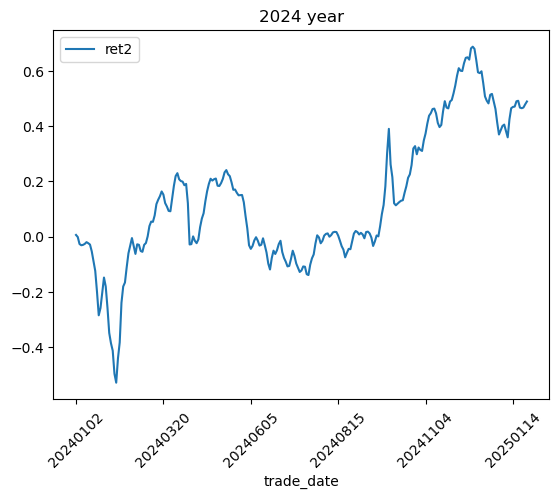

In [37]:
## 考虑t+1开盘买 t+2收盘卖的收益情况
tmp = test.copy()
tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)] 
num = 300
tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('trade_date').ret2.mean() - 1.0005)
(ret_pd1.loc['20240101':,] ).cumsum().plot(rot=45, title = '2024 year')


In [38]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min().values[0]
    end = returns.index[dd.values.argmin()]
    start = returns.index[r.loc[:end].values.argmax()]
    return mdd, start, end


def calc_pfmc(ret_PD):
    ret_PD_ = ret_PD.copy()
    performance = []
    ret_PD_.columns = ['ret']
    returnlist = ret_PD_['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()
    
    ret2_len = pd.DataFrame(tmp.groupby('trade_date').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]
    max_draw, start, end = max_dd(ret_PD)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    
    

    return performance

In [39]:
calc_pfmc(ret_pd1)

,group_name,return,sharpe,std,winratio,mdd
0,LGB,0.476177,0.889061,0.033739,0.544061,-0.53252


In [40]:
## 看某天的股票持仓
tmp[tmp.trade_date=='20240223'][['ts_code','name','trade_date','pred','ret','ret1','ret2']].head(10)

,ts_code,name,trade_date,pred,ret,ret1,ret2
9600,002021.SZ,中捷资源,20240223,5.942169,1.011628,1.011628,1.011628
9601,002086.SZ,东方海洋,20240223,5.598650,0.995781,1.000000,0.995781
9602,000620.SZ,新华联,20240223,5.550044,1.046667,1.046980,1.046667
9603,300010.SZ,豆神教育,20240223,5.538190,1.021834,1.022026,1.021834
9604,002482.SZ,广田集团,20240223,5.491253,1.029586,1.035503,1.029586
9605,600530.SH,交大昂立,20240223,5.463817,0.995798,0.995763,0.995798
9606,002157.SZ,正邦科技,20240223,5.460017,1.053719,1.049587,1.053719
9607,603030.SH,全筑股份,20240223,5.448274,0.974895,0.962656,0.974895
9608,002697.SZ,红旗连锁,20240223,5.418385,1.002119,0.989407,1.002119
9609,600527.SH,江南高纤,20240223,5.364834,1.023529,1.005848,1.023529


## 对冲收益

In [41]:
## 计算对冲的收益
dfindex = pro.index_daily(ts_code='000852.SH', start_date=ret_pd1.index[0], end_date=ret_pd1.index[-1])   #zz1000
# dfindex = pro.index_daily(ts_code='399905.SZ', start_date=ret_pd1.index[0], end_date=ret_pd1.index[-1])  #zz500
dfindex = dfindex[['trade_date','pct_chg']].set_index('trade_date').sort_index()
dfindex

,pct_chg
trade_date,
20240102,-0.5518
20240103,-0.5245
20240104,-0.7044
20240105,-1.8538
20240108,-2.3298
...,...
20250122,-0.8850
20250123,-0.4561
20250124,1.8716


In [42]:
ret_pd_concat = pd.merge(ret_pd1,dfindex/100,left_index=True, right_index=True)
ret_pd_concat.columns = ['ret','dfindex']
ret_pd_concat['diff'] = ret_pd_concat['ret'] - ret_pd_concat['dfindex']
ret_pd_concat

,ret,dfindex,diff
trade_date,,,
20240102,0.005649,-0.005518,0.011167
20240103,-0.007558,-0.005245,-0.002313
20240104,-0.025255,-0.007044,-0.018211
20240105,-0.004610,-0.018538,0.013928
20240108,0.001422,-0.023298,0.024720
...,...,...,...
20250122,0.002514,-0.008850,0.011364
20250123,0.011526,-0.004561,0.016087
20250124,0.010334,0.018716,-0.008382


In [43]:
ret_pd_concat.corr()

,ret,dfindex,diff
ret,1.000000,0.090591,0.835654
dfindex,0.090591,1.000000,-0.471296
diff,0.835654,-0.471296,1.000000


<AxesSubplot:title={'center':'2022-2024 year'}, xlabel='trade_date'>

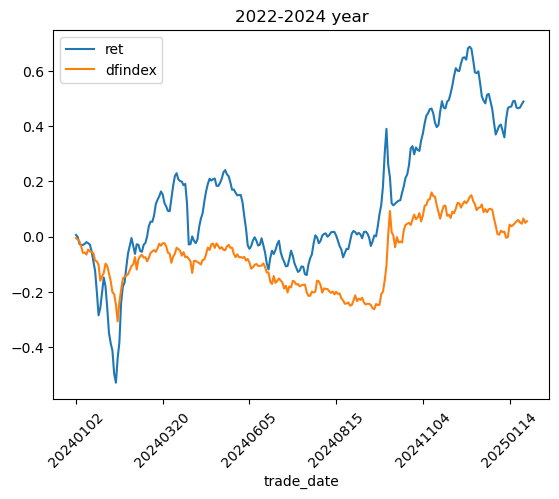

In [46]:
(ret_pd_concat[['ret','dfindex']].cumsum()).plot(rot=45, title = '2022-2024 year')


In [45]:
calc_pfmc(ret_pd_concat[['diff']])

,group_name,return,sharpe,std,winratio,mdd
0,LGB,0.41287,0.682687,0.038097,0.517241,-0.319118
